# Modifying MCMC Initial Positions

This section aims at initializing the walkers around the known paramter space to constrain HD 159062 orbital parameters in a "ball". Scattering the walkers randomly even after 11 iterations may take much longer to converge. This section follows the Orbitize! tutorial by Henry Ngo: https://orbitize.readthedocs.io/en/latest/tutorials/Modifying_MCMC_initial_positions.html

In [1]:
import numpy as np
import custom_hd159062_lnlike as custom_lnlike
from orbitize import sampler,driver,kepler,system,results,lnlike
import multiprocessing as mp
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from astropy.time import Time
from datetime import datetime
import os

In [38]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=17)
plt.rc('axes', linewidth=1)

In [2]:
def M2tperi(M,P,tref):
    Tp = tref - M*P/(2*np.pi)
    return Tp #time of periastron from mean anomaly

def M2tau0(M,P,tref):
    Tp = M2tperi(M,P,tref)
    tau = Tp/P % 1
    return tau #tau from mean anomaly

def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P #fraction of orbit after tperi

def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0+m1))**(1/3) #sma in AU

def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

In [3]:
#parameters for the white dwarf based on Lea's paper:
M = 144.0*np.pi/180
P = 238*365.25
wd_tref = 2452832.92

sma = p2sma(238*365.25,0.80,0.65)
ecc = 0.44
inc = 53.0*np.pi/180
argp = (-26+180)*np.pi/180
lan = (138.0+180)*np.pi/180
tau = M2tau0(M,P,wd_tref)
plx = 46.12
gamma = 934.0 #(in the K band)
sigma = 2.3 #(in the K band)
m1 = 0.65
m0 = 0.80

wd_params = [sma,ecc,inc,argp,lan,tau,plx,gamma,sigma,m1,m0]
print(wd_params)
print(M2tperi(M,P,wd_tref))
print('Period:', P)
print('Mean anomaly:',M)

[43.468431757814514, 0.44, 0.9250245035569946, 2.6878070480712677, 5.550147021341968, 0.8163468097711366, 46.12, 934.0, 2.3, 0.65, 0.8]
2418061.12
Period: 86929.5
Mean anomaly: 2.5132741228718345


In [4]:
chains = pd.read_csv('/Users/rtejada/Desktop/notebooks/HD159062/samp_0temp.csv')
chains

cosi     jit_j      jit_k       lan      lnlike      lnprob  \
0     0.715106  0.972748   5.857269  5.601356  194.658102  192.450067   
1     0.457901  1.578017   2.767363  5.473243  192.380294  188.501841   
2     0.921475  2.209806   2.901356  5.810537  188.775868  187.496116   
3     0.878406  1.508978   6.947793  5.810539  187.391019  185.571212   
4     0.693423  1.786361   0.375250  5.631091  196.465976  195.986498   
5     0.886173  1.187360  11.137766  5.937817  193.424262  192.584041   
6     0.664115  1.456354   7.899835  5.686061  195.387191  193.805105   
7     0.494393  1.483145   5.774975  5.574683  195.548811  192.974694   
8     0.762505  1.284642   6.315654  5.646780  197.196076  195.352763   
9     0.895908  1.905894   0.415100  5.818551  193.392751  192.869949   
10    0.664052  1.234365   1.029701  5.601430  198.622843  198.350049   
11    0.639824  1.812289   2.255235  5.584828  198.146716  197.505081   
12    0.654816  1.542222   0.608170  5.585741  198.903319  197.797528   
13    0.627396  1.405397   3.524273  5.567474  196.519279  195.971707   
14    0.511875  1.217172   1.070743  5.476618  200.772329  199.142433   
15    0.513309  1.800284   3.848082  5.456587  193.868445  193.181498   
16    0.461877  1.580808   0.111824  5.507832  198.796764  197.875867   
17    0.560475  1.307575   1.696243  5.514888  199.311856  198.505469   
18    0.629374  1.600191   1.020993  5.657401  197.592982  196.018667   
19    0.785168  1.240054   1.314965  5.822682  198.947210  195.158460   
20    0.467658  1.025188   3.063654  5.465657  197.400991  196.764529   
21    0.764135  1.161428   3.047638  5.665345  199.414396  199.148576   
22    0.448805  1.237217   1.602033  5.504311  196.201720  195.999041   
23    0.480938  1.757424   3.490815  5.471343  195.176521  193.780496   
24    0.800193  1.288801   3.440556  5.632261  195.054158  191.681478   
25    0.617843  2.264820   0.151356  5.532508  195.584303  195.499591   
26    0.782410  1.444408   0.025250  5.597077  197.390841  193.753508   
27    0.449929  2.006845   3.983630  5.442012  194.135113  193.645904   
28    0.455270  2.042879   0.971962  5.456724  189.808752  188.772817   
29    0.423979  1.610723   5.025060  5.458929  195.015160  194.515635   
...        ...       ...        ...       ...         ...         ...   
9970  0.724101  1.228896   6.740987  5.654055  197.245193  196.467973   
9971  0.429275  1.574800   3.622328  5.436722  197.902400  197.682049   
9972  0.541760  1.142063   3.025573  5.516752  198.271022  195.909532   
9973  0.467036  1.288876   0.535417  5.432207  196.199004  195.961455   
9974  0.783080  1.202323   2.410066  5.828836  195.990774  194.867538   
9975  0.415801  1.513283   1.129623  5.457465  197.700508  197.096523   
9976  0.598639  1.632561   0.559342  5.574893  198.572883  198.273031   
9977  0.958965  1.413729   1.488386  5.973247  199.724403  199.387369   
9978  0.745987  1.804693   4.836848  5.521062  192.890429  188.935555   
9979  0.433903  1.292302   1.936562  5.448497  199.158464  197.825935   
9980  0.637692  1.220164   0.407330  5.683413  196.876310  191.761665   
9981  0.662959  1.696801   2.160843  5.601195  194.482883  193.523586   
9982  0.457350  1.913338   0.087293  5.455985  197.294223  195.870356   
9983  0.862820  1.651537   0.785243  5.743407  199.129412  198.790907   
9984  0.441476  2.082957   1.263000  5.460846  197.036690  194.361211   
9985  0.541655  1.119040   1.651262  5.536403  198.790918  198.113174   
9986  0.532695  0.918046   2.143225  5.512920  196.826798  194.397051   
9987  0.695524  0.836655   1.996862  5.690162  196.583250  196.048396   
9988  0.479752  1.722139   8.798570  5.600051  190.095482  186.991948   
9989  0.473886  1.370599   1.950423  5.470540  198.056125  197.020759   
9990  0.455841  1.227882   3.347551  5.452537  197.486874  195.224807   
9991  0.765176  1.474264   4.084796  5.707333  193.961306  190.903170   
9992  0.502299  1.101619   1.361969  5.487779  196.820731  196.52101

In [5]:
chains['sma'] = p2sma(chains['per']*365.25,chains['m1'],chains['m2'])

In [6]:
chains['tau'] = M2tau0(chains['manom'],chains['per'],wd_tref)

wd_params = [sma,ecc,inc,argp,lan,tau,plx,gamma,sigma,m1,m0]

In [7]:
param_cols = chains[['sma','ecc','inc','argp','lan','tau','para','off_j','jit_j','m2','m1']]
param_cols.head()

sma       ecc       inc      argp       lan       tau       para  \
0  36.727752  0.705326  0.774021  2.827732  5.601356  0.259461  46.148410   
1  60.462330  0.108127  1.095164  1.589445  5.473243  0.939483  46.092618   
2  33.039123  0.860713  0.398936  2.654219  5.810537  0.091820  46.113460   
3  34.408428  0.776087  0.498281  2.619547  5.810539  0.000065  46.086688   
4  38.048164  0.680836  0.804567  2.805234  5.631091  0.675672  46.141065   

         off_j     jit_j        m2        m1  
0   532.034851  0.972748  0.711760  0.748508  
1  1487.405394  1.578017  0.620162  0.810618  
2    94.170814  2.209806  0.995189  0.796273  
3   255.895243  1.508978  0.813358  0.778809  
4   486.464272  1.786361  0.653415  0.774329

In [8]:
param_cols['argp'] = param_cols['argp'] % 2*np.pi

/Users/rtejada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
param_cols.shape

(10000, 11)

In [10]:
param_cols.values.tolist()

[[36.7277524986288,
  0.705325951476,
  0.774020562879,
  2.600397389454851,
  5.601356142059998,
  0.2594611560798512,
  46.1484102479,
  532.0348513490001,
  0.972747660649,
  0.711760195846,
  0.7485084271060001],
 [60.46232959312201,
  0.108127166795,
  1.09516395539,
  4.993389184784106,
  5.47324336414,
  0.9394830900537272,
  46.092618136800006,
  1487.40539387,
  1.5780169382799998,
  0.620161541896,
  0.810617845343],
 [33.039123168010676,
  0.860713187668,
  0.398935899705,
  2.055288651959296,
  5.810537170519999,
  0.09182034357945668,
  46.1134601849,
  94.1708144733,
  2.20980575036,
  0.995189498339,
  0.796273158856],
 [34.4084279008405,
  0.776086506953,
  0.498280775814,
  1.9463654172596954,
  5.81053939248,
  6.530312020913698e-05,
  46.0866877741,
  255.895243156,
  1.50897804773,
  0.8133578979330001,
  0.7788090119059999],
 [38.04816418845293,
  0.680835600217,
  0.804567025869,
  2.529715836080133,
  5.63109069822,
  0.6756722472655383,
  46.1410651806,
  486.46

In [11]:
orbits_reshaped = np.reshape(param_cols.values.tolist(),(20,-1,11))

In [12]:
np.shape(orbits_reshaped)

(20, 500, 11)

In [13]:
params_4poster = ['sma','e','i','$\omega$','$\Omega$','$\\tau$']

In [14]:
np.shape(flatchain)

NameError: name 'flatchain' is not defined

In [ ]:
mod_flatchain = pd.DataFrame(flatchain[:,:6],columns=params_4poster)
np.shape(mod_flatchain)

In [ ]:
print(mod_flatchain)

In [ ]:
m0_pred = pd.DataFrame(flatchain[:,-2])

In [ ]:
mod_flatchain.insert(loc=0,column='M1',value=m0_pred)

In [ ]:
mod_flatchain

In [ ]:
list(mod_flatchain.columns)

In [ ]:
print(np.shape(mod_flatchain))

In [ ]:
corner_fig = corner.corner(mod_flatchain,labels = list(mod_flatchain.columns),
                           quantiles=[0.16,0.5,0.84],
                          show_titles=True,
                           #range=np.ones(len(list(mod_flatchain.columns)))*0.99,
                           title_kwargs={"fontsize": 18})
corner_fig.savefig('/Users/rtejada/Desktop/cornerplot_4poster.pdf')

In [ ]:
epochs = my_driver.system.data_table['epoch']

orbit_figure = m.results.plot_orbits(
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    num_orbits_to_plot=20
)
ax_orb, ax_cbar, ax_sep, ax_pa  = orbit_figure.axes

In [ ]:
epochs_yr = Time(epochs, format='mjd').decimalyear
sep = my_mcmc.system.data_table['quant1'] ; sep_err = my_mcmc.system.data_table['quant1_err']
pa = my_mcmc.system.data_table['quant2'] ; pa_err = my_mcmc.system.data_table['quant2_err']

In [ ]:
orbit_figure.suptitle('HD 159062: 20 Orbits - MCMC Results With RV Data')
ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_orb.set_xlabel('$\Delta$ RA [mas]')
ax_orb.set_ylabel('$\Delta$ DEC [mas]')
ax_orb.invert_xaxis()
ax_orb.set_xlim(-5000,5000)
ax_orb.set_ylim(-5000,5000)
ax_sep.set_ylim(2300,2800)
ax_orb.minorticks_on()
ax_pa.errorbar(epochs_yr,pa,pa_err,color='purple',linestyle='',fmt='.',zorder=3)
ax_sep.errorbar(epochs_yr,sep,sep_err,color='purple',linestyle='',fmt='.',zorder=3)
orbit_figure.savefig('/Users/rtejada/Desktop/HD159062_orbitplot_4poster_mcmc_wrvdata_noclike.pdf')

# Including our Custom Likelihood with Defined Initial Positions of MCMC

In [27]:
filename = '/Users/rtejada/Desktop/notebooks/HD159062/hd159062_mcmc.csv'

# system parameters
num_secondary_bodies = 1
system_mass = m0 # [Msol]
plx = plx # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.024 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 100
num_threads = mp.cpu_count() # or a different number if you prefer


my_mcmc = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0, 'gamma_bounds':(-5000, 5000), 'jitter_bounds':(1e-3, 50)},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input

In [28]:
#attempt at adding our custom log-likelihood:
my_mcmc.sampler.custom_lnlike=custom_lnlike.custom_sum_chi2_loglike

In [29]:
m = my_mcmc.sampler
m.curr_pos = orbits_reshaped[:,:100,:]

In [30]:
m.curr_pos.shape

(20, 100, 11)

In [31]:
total_orbits = 500000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 100 # steps to burn in per walker
thin = 50# only save every 10th step

In [ ]:
today = datetime.now()
path = '/Users/rtejada/Desktop/'
param_names = ['sma','e','i','$\omega$','$\Omega$','$\\tau$','$\pi$','$\gamma$',
               '$\sigma$','M1','M0']

#change 'simuldata2' when running different data!!!

directory = path + 'HD159062/mcmcrun/' + today.strftime('%Y%m%d') + '/'
os.makedirs(directory)

for i in range(10):
    #running the sampler:
    m.run_sampler(total_orbits, burn_steps=0, thin=thin)
    chain = m.chain
    print('The chain shape is:',np.shape(chain))
    #saving each sampler chainL
    pkl_file = open(directory + 'mcmcchains_run%1d.txt' % i,'wb')
    pickle.dump(chain,pkl_file)
    
    #plotting and saving corner plots:
    corner_plot_fig = m.results.plot_corner(show_titles=True,
                                     quantiles=[0.16,0.5,0.84]) # Creates a corner plot and returns Figure object
    corner_plot_fig.savefig(directory + 'cornerplot%1d.pdf' % i)
    
    for j in range(15):
        with PdfPages(directory+'mcmc%1d_temps%1d.pdf' % (i,j)) as pdf:
            shape = np.shape(chain)
            num_steps = shape[2]
            num_params = shape[3]
            num_walkers = shape[1]
            for p in range(num_params):
                pname = param_names[p]
                fig = plt.figure(figsize = (8,5))
                for x in range(num_walkers):
                    #makes trend plot
                    plt.plot(range(num_steps),m.chain[j,x,:,p],alpha=0.7,linewidth=2)
                    #plt.axhline(wd_params[p],ls='--',c='k')
                plt.ylabel(pname)
                plt.xlabel('steps')
                plt.minorticks_on()
                pdf.savefig()
                #plt.show()
                plt.close()
    print('Finished with %1d iterations!' % i)
                
flatchain = np.reshape(chain[0],(-1,11))
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,range=np.ones(len(param_names))*0.99,title_kwargs={"fontsize": 17})
corner_fig.savefig(directory + 'flatchain_cornerplot.pdf')

Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

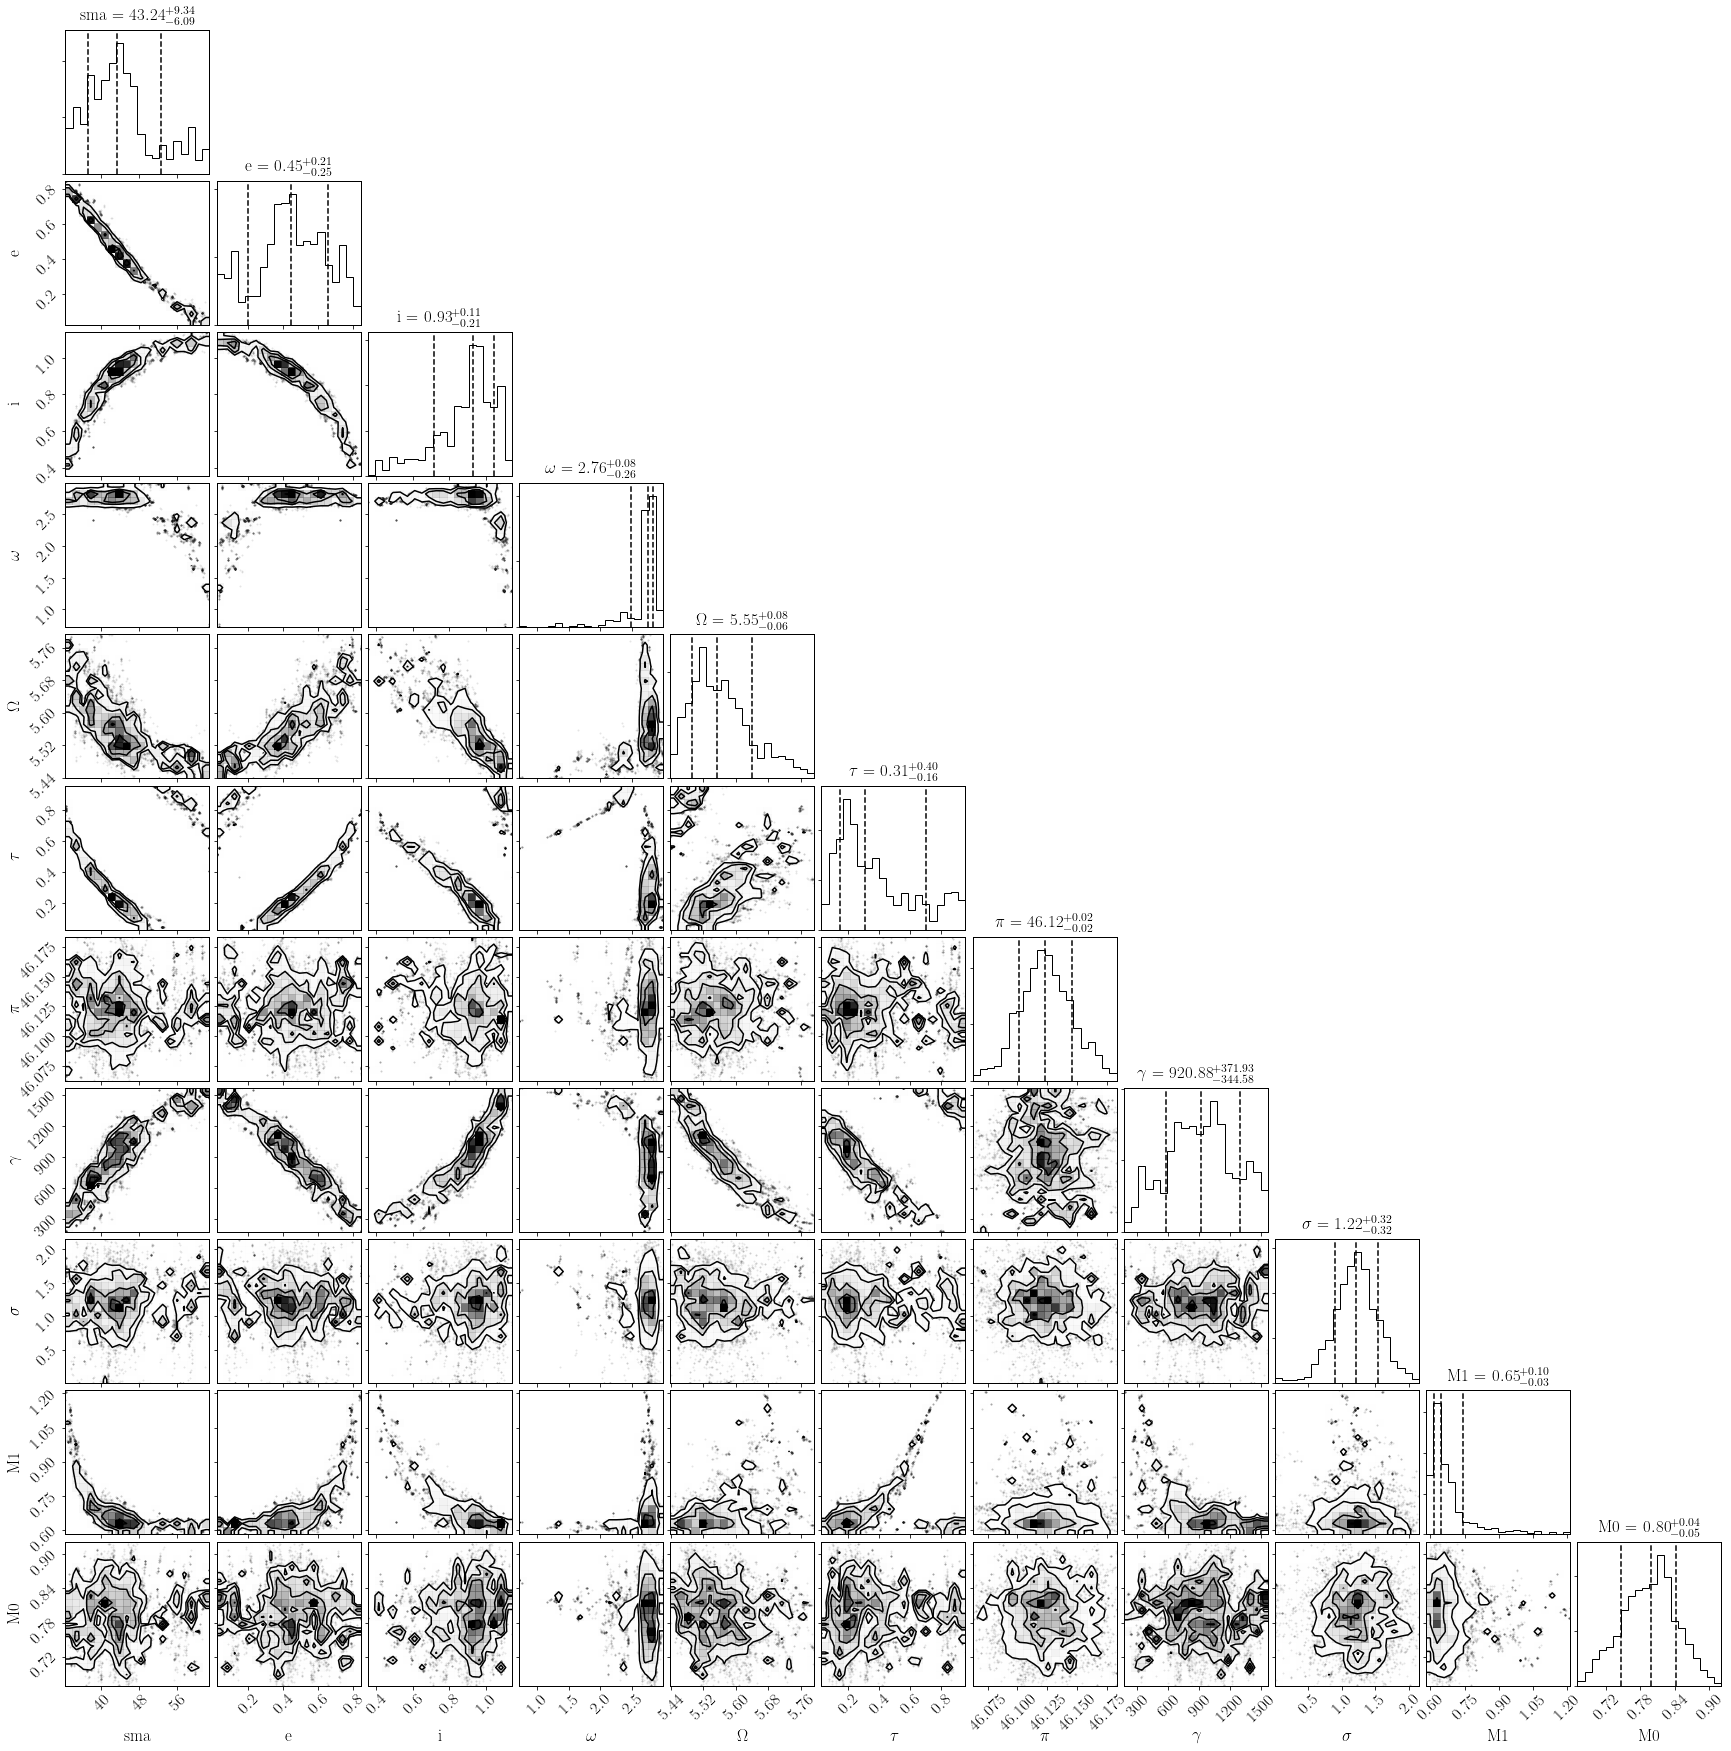

In [48]:
flatchain = np.reshape(chain[0],(-1,11))
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,range=np.ones(len(param_names))*0.99,title_kwargs={"fontsize": 17})
corner_fig.savefig(path + 'hd159062_flatchain_cornerplot_init_pos0_wclike.pdf')

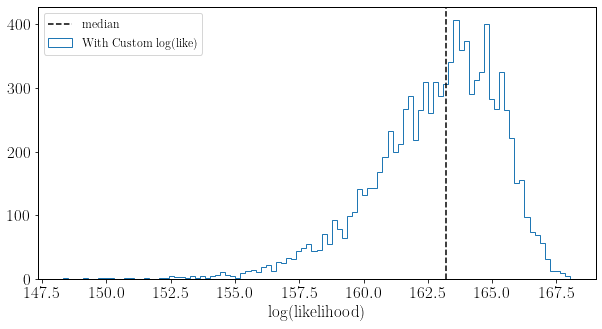

In [51]:
plt.figure(figsize=(10,5))
plt.hist(m.lnlikes,bins=100,histtype='step',label='With Custom $\log(\mathrm{like})$')
#plt.hist(s.lnlikes,bins=100,histtype='step',label='Without Custom $\log(\mathrm{like})$')
plt.axvline(x=np.median(m.lnlikes),c='k',ls='--',label='median')
#plt.axvline(x=np.median(s.lnlikes),c='k',ls='--')
plt.xlabel('$\log(\mathrm{likelihood})$')
plt.legend(loc='upper left',prop={'size': 12})
plt.show()

In [ ]:
mod_flatchain2 = pd.DataFrame(flatchain[:,:6],columns=params_4poster)
m0_pred2 = pd.DataFrame(flatchain[:,-2])
mod_flatchain2.insert(loc=0,column='M1',value=m0_pred)

In [ ]:
corner_fig2 = corner.corner(mod_flatchain2,labels = list(mod_flatchain2.columns),
                           quantiles=[0.16,0.5,0.84],
                          show_titles=True,
                           #range=np.ones(len(list(mod_flatchain.columns)))*0.99,
                           title_kwargs={"fontsize": 18})
corner_fig2.savefig('/Users/rtejada/Desktop/cornerplot_4poster_wclike_new.pdf')

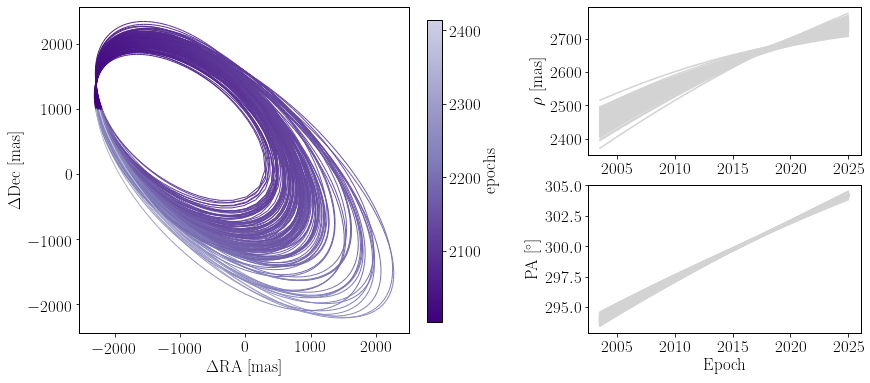

In [58]:
epochs = my_mcmc.system.data_table['epoch']

orbit_figure = m.results.plot_orbits(
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    num_orbits_to_plot=150
)
ax_orb, ax_cbar, ax_sep, ax_pa  = orbit_figure.axes

In [59]:
epochs_yr = Time(epochs, format='mjd').decimalyear
sep = my_mcmc.system.data_table['quant1'] ; sep_err = my_mcmc.system.data_table['quant1_err']
pa = my_mcmc.system.data_table['quant2'] ; pa_err = my_mcmc.system.data_table['quant2_err']

In [60]:
#orbit_figure.suptitle('HD 159062: 50 Orbits - MCMC Results With RV Data and Custom Likelihood')
ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_orb.set_xlabel('$\Delta$ RA [mas]')
ax_orb.set_ylabel('$\Delta$ DEC [mas]')
ax_orb.set_xlim(-5000,5000)
ax_orb.set_ylim(-5000,5000)
ax_sep.set_ylim(2300,2800)
ax_orb.minorticks_on()
ax_orb.invert_xaxis()
ax_pa.errorbar(epochs_yr,pa,pa_err,color='purple',linestyle='',fmt='.',zorder=3)
ax_sep.errorbar(epochs_yr,sep,sep_err,color='purple',linestyle='',fmt='.',zorder=3)
orbit_figure
orbit_figure.savefig('/Users/rtejada/Desktop/HD159062_orbitplot_4poster_mcmc_wrvdata_wclike.pdf')

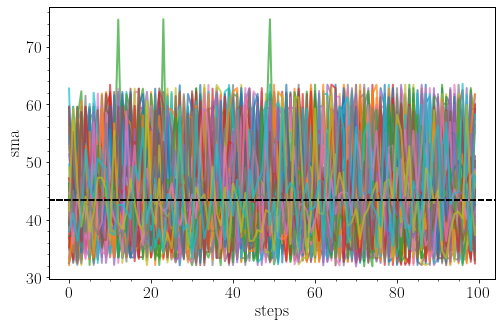

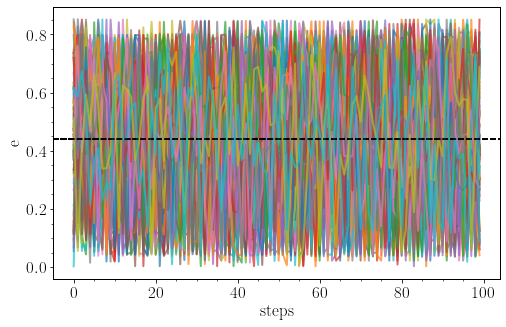

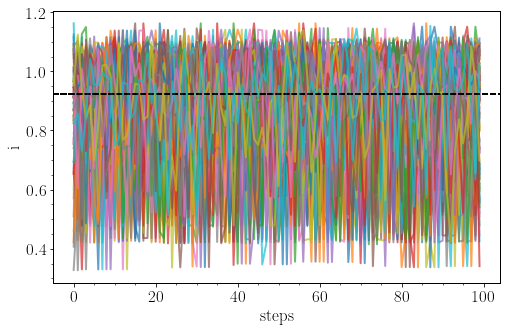

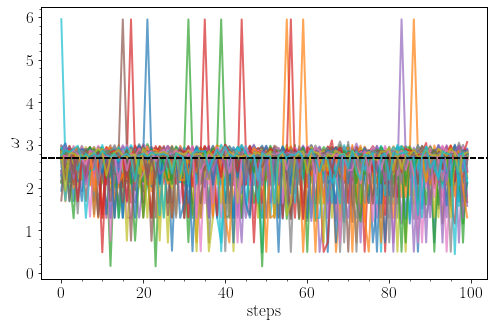

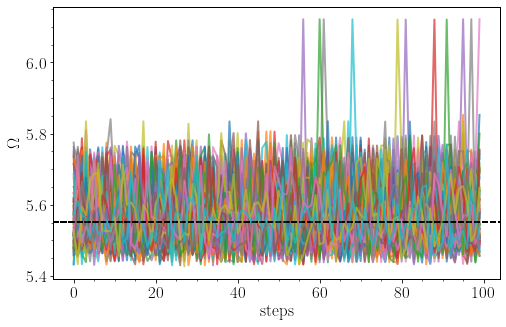

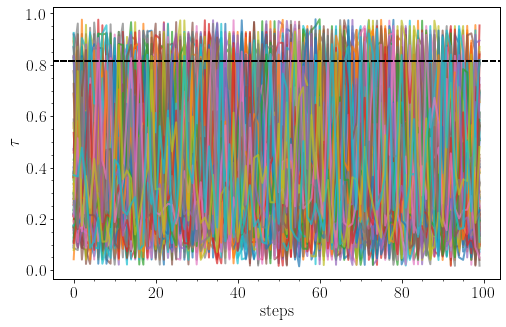

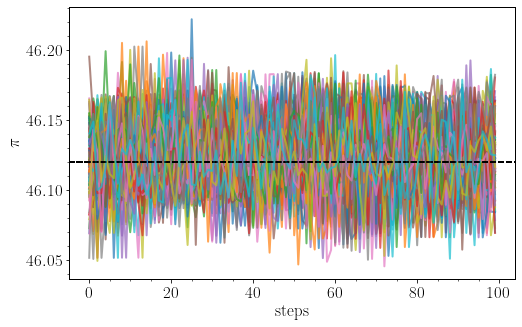

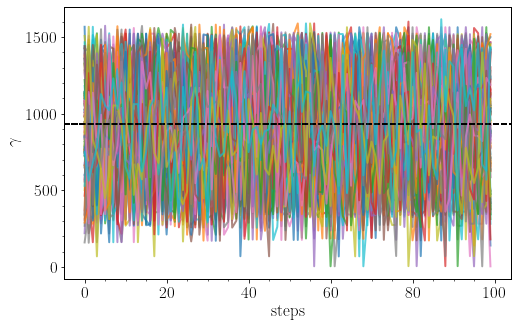

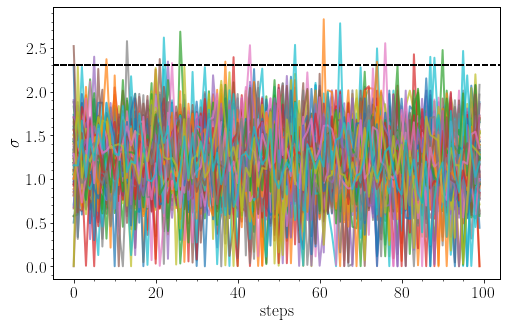

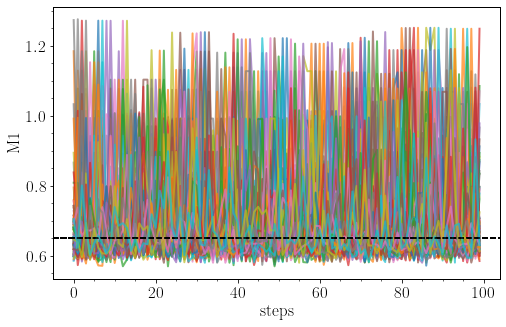

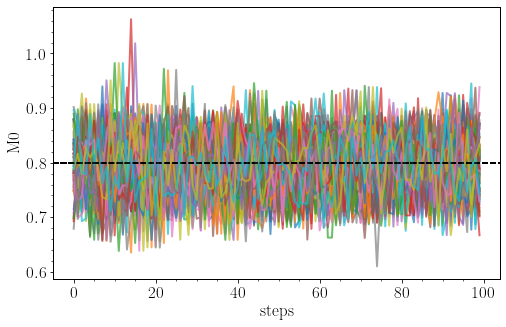

In [56]:
shape = np.shape(chain)
num_steps = shape[2]
num_params = shape[3]
num_walkers = shape[1]
for p in range(num_params):
    pname = param_names[p]
    fig = plt.figure(figsize = (8,5))
    for x in range(num_walkers):
        #makes trend plot
        plt.plot(range(num_steps),m.chain[0,x,:,p],alpha=0.7,linewidth=2)
        plt.axhline(wd_params[p],ls='--',c='k')
    plt.ylabel(pname)
    plt.xlabel('steps')
    plt.minorticks_on()
    plt.show()

In [ ]:
my_mcmc_lnlike = m.results.lnlike

In [ ]:
np.shape(my_mcmc_lnlike)

In [ ]:
#print('Shape of lnlikes for all temperatures:',my_mcmc_lnlikes.shape)
print(my_mcmc_lnlike)

In [ ]:
plt.hist(my_mcmc_lnlike,histtype='step')
plt.show()

In [ ]:
m.results.lnlike

In [ ]:
np.shape(chain)

In [ ]:
np.shape(flatchain)

In [ ]:
# compute the model based on system params
model, jitter = system.System.compute_model(my_mcmc.system,flatchain)

# fold data/errors to match model output shape. In particualr, quant1/quant2 are interleaved
data = np.array([my_mcmc.system.data_table['quant1'], my_mcmc.system.data_table['quant2']]).T
errs = np.array([my_mcmc.system.data_table['quant1_err'],
                my_mcmc.system.data_table['quant2_err']]).T

# TODO: THIS ONLY WORKS FOR 1 PLANET. Make this a for loop to work for multiple planets.
seppa_indices = np.union1d(my_mcmc.system.seppa[0], my_mcmc.system.seppa[1])
# compute lnlike
# Rob: added the jitter term here
lnlikes = lnlike.chi2_lnlike(data, errs, model, jitter, seppa_indices)

# return sum of lnlikes (aka product of likeliehoods)
lnlikes_sum = np.nansum(lnlikes, axis=(0, 1))

custom_lnlike_sum = []
for i in range(10000):
    params = flatchain[i,:]
    clnlike = custom_lnlike.custom_chi2_loglike(params)
    custom_lnlike_sum.append(clnlike)

In [ ]:
plt.hist(lnlikes_sum,histtype='step')
plt.show()

In [ ]:
plt.hist(custom_lnlike_sum,histtype='step')
plt.show()